<a href="https://colab.research.google.com/github/kinianlo/prlang/blob/main/archive/pr_lang_adj_sheaf_contextual_11k_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PR-like models in langauge


### Generate PR-like models with Masked LM 

In [1]:
!pip install numpy inflect torch transformers
%cd
%rm -rf contextuality/
!git clone https://github.com/kinianlo/contextuality.git
%cd contextuality
!pip install .


/root
Cloning into 'contextuality'...
remote: Enumerating objects: 105, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 105 (delta 28), reused 92 (delta 18), pack-reused 0
Receiving objects: 100% (105/105), 23.62 KiB | 2.95 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/root/contextuality
Processing /root/contextuality
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for Contextuality: filename=Contextuality-0.0.1-py3-none-any.whl size=10504 sha256=860e8463100906a99e690a7c1753144b140f1c25148a332093d5e2bae6e01c2c
  Stored in directory: /tmp/pip-ephem-wheel-c

In [2]:
%cd
%rm -rf prlang
!git clone https://github.com/kinianlo/prlang.git
!cp prlang/adjectives.txt /root/adjectives.txt
!cp prlang/verbs.txt /root/verbs.txt

/root
Cloning into 'prlang'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 34 (delta 13), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [3]:
import itertools
import numpy as np
import inflect
import random
import json

import torch
from transformers import AutoModelForMaskedLM, AutoTokenizer
from transformers import logging
logging.set_verbosity_error()

In [4]:
def get_probs(sentences_raw, options, model, tokenizer, mask_placeholder='_'):
    torch.cuda.empty_cache()
    if type(sentences_raw) is str:
        sentences_raw = [sentences_raw]
    if type(options[0]) is str:
        options = [options for s in sentences_raw]
    
    partition_size = 2**8
    n_sentence = len(sentences_raw)
    if n_sentence > partition_size:
        print(f"Number of sentences = {n_sentence} > {partition_size}.")
        probs = []
        for i in range(0, len(sentences_raw), partition_size):
            print(f"Currently on {i}/{n_sentence}")
            sentences_raw_part = sentences_raw[i:i+partition_size]
            options_part = options[i:i+partition_size]
            probs += get_probs(sentences_raw_part, options_part, model,
                               tokenizer, mask_placeholder=mask_placeholder)
        return probs
        
    # Convert the option words into tokens
    options_token = [[tokenizer.tokenize(op)[0] for op in ops] for ops in options]
    options_id = [[tokenizer.vocab[op] for op in ops] for ops in options_token]
    
    # Replace mask placeholders with the mask token used by the given tokenizer
    sentences = [s.replace(mask_placeholder, tokenizer.mask_token) for s in sentences_raw]
    inputs = tokenizer(sentences, return_tensors='pt', padding=True).to(model.device)
    
    mask_indices = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)
    
    outputs = model(**inputs)
    logits = outputs.logits
    
    mask_logits = logits[mask_indices]
    
    probs = [[] for i in range(len(sentences))]
    
    for i in range(len(mask_indices[0])):
        s_idx, m_idx = mask_indices[0][i], mask_indices[1][i]
        prob = torch.softmax(mask_logits[i][options_id[s_idx]], dim=-1).detach().cpu().numpy()
        prob = dict(zip(options[s_idx], prob))
        probs[s_idx].append(prob)
        
    if len(probs) == 1:
        probs = probs[0]
    return probs

In [5]:
# Initialise the language model and its tokenizer
device = "cuda:0" if torch.cuda.is_available() else "cpu"
lm_name = 'bert-base-uncased'
mlm = AutoModelForMaskedLM.from_pretrained(lm_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(lm_name)

In [6]:
## Playground
### Uncomment this cell to play with the get_probs function 
#outcomes = ['apple', 'strawberry']
#observables = ['sweet', 'red', 'round']
#intro = f"There is an {outcomes[0]} and a {outcomes[1]}."
#contexts = [f"The _ is {observables[0]} and {observables[1]}.",
#            f"The _ is {observables[1]} and {observables[2]}.",
#            f"The _ is {observables[2]} but the other is {observables[0]}."]
#probs = get_probs([f"{c}" for c in contexts], [outcomes for i in range(3)], mlm, tokenizer)
#for i, context in enumerate(contexts):
#    print(context)
#    print(probs[i])

## The following handles a batch of examples
Examples should be given in a text file where each row has the format:

```outcome1 outcome2: observable1 observable2 observable3 observable4 ...```

For example,

```apple strawberry: sweet red round green big```

For each row, all ordered combinations of 3 observables will be considered in the following.

In [7]:
def process_topics_file(file_name):
    topics = []
    with open(file_name) as file:
        for row in file:
            outcomes = [] 
            observables = []
            outcomes_str, observables_str = map(str.strip, row.split(':'))
            outcomes = list(map(str.strip, set(outcomes_str.split(','))))
            observables = list(map(str.strip, set(observables_str.split(','))))
            topics.append((outcomes, observables))
    return topics

def process_schemas_file(file_name):
    schema_options = dict()
    schemas = dict()
    with open(file_name) as file:
        data = json.load(file)
        schema_options = data['options']
        schemas = data['schemas']
    return schema_options, schemas

In [8]:
def generate_scenarios(topics, schema):
    scenarios = []
    if schema == 'adj':
        for topic in topics:
            outcomes, observables = topic
            out_perm = itertools.permutations(outcomes, 2)
            obs_perm = itertools.permutations(observables, 3)
            scenarios += list(itertools.product(out_perm, obs_perm))
    elif schema == 'adj_no_intro':
        for topic in topics:
            outcomes, observables = topic
            out_perm = itertools.combinations(outcomes, 2)
            obs_perm = itertools.permutations(observables, 3)
            scenarios += list(itertools.product(out_perm, obs_perm))
    return scenarios

In [9]:
def a(word):
    return inflect.engine().a(word)

def generate_sentences(scenario, schema):
    sentences = []
    o, x = scenario
    if schema == 'adj':
        intro = f"There is {a(o[0])} and {a(o[1])}."
        sentences.append(f"{intro} The _ is {x[0]} and {x[1]}.")
        sentences.append(f"{intro} The _ is {x[1]} and {x[2]}.")
        sentences.append(f"{intro} The _ is {x[2]} and the other one is {x[0]}.")
    elif schema == 'adj_no_intro':
        sentences.append(f"The _ is {x[0]} and {x[1]}.")
        sentences.append(f"The _ is {x[1]} and {x[2]}.")
        sentences.append(f"The _ is {x[2]} and the other one is {x[0]}.")
    return sentences

def get_mask_options(scenario, schema):
    o, x = scenario
    return [o for i in range(3)]

## Load topics files

In [10]:
topics = process_topics_file('adjectives.txt') 
schema = 'adj'

print(f'Loaded topics for schema `{schema}`:')
for t in topics:
    print(t)

Loaded topics for schema `adj`:
(['cat', 'dog'], ['sweet', 'thirsty', 'furry', 'big', 'large', 'wild', 'young', 'good', 'cute', 'hungry', 'lovely', 'gray', 'dead', 'friendly', 'little', 'house', 'small', 'black'])
(['girl', 'boy'], ['beautiful', 'young', 'little', 'baby', 'teenage', 'small', 'pretty'])
(['man', 'woman'], ['big', 'beautiful', 'dead', 'strange', 'tall', 'little', 'young'])
(['apple', 'strawberry', 'cherry'], ['sweet', 'rotten', 'round', 'sour', 'red'])
(['marigold', 'daisy'], ['everywhere', 'beautiful', 'small', 'yellow'])
(['sunflower', 'coreopsis', 'daisy'], ['beautiful', 'small', 'yellow'])
(['moth', 'butterfly'], ['colorful', 'beautiful', 'winged', 'light'])
(['courgette', 'cucumber'], ['green', 'juicy', 'tasty', 'long'])
(['porpoise', 'dolphin'], ['grey', 'slippery', 'wet', 'slim'])
(['yam', 'potato'], ['orange', 'healthy', 'big', 'starchy'])
(['car', 'bus'], ['safe', 'heavy', 'fast', 'sturdy'])


In [11]:
scenarios = generate_scenarios(topics, schema)

# Too many scenarios would require too much computing time
# So randomly select a few to continue
random.shuffle(scenarios)
scenarios = scenarios[:]

n_scenario = len(scenarios)
print(f"Number of scenarios: {n_scenario}")

Number of scenarios: 11316


In [12]:
from time import time
sentences = [generate_sentences(scen, schema) for scen in scenarios]
sentences_flat = list(itertools.chain.from_iterable(sentences))

mask_options = [get_mask_options(scen, schema) for scen in scenarios]
mask_options_flat = list(itertools.chain.from_iterable(mask_options))

start = time()
probs_flat = get_probs(sentences_flat, mask_options_flat, mlm, tokenizer)
end = time()
print(f"BERT took {end-start:.1f} seconds.")
probs = [probs_flat[3*i:3*i+3] for i in range(n_scenario)]

Number of sentences = 33948 > 256.
Currently on 0/33948
Currently on 256/33948
Currently on 512/33948
Currently on 768/33948
Currently on 1024/33948
Currently on 1280/33948
Currently on 1536/33948
Currently on 1792/33948
Currently on 2048/33948
Currently on 2304/33948
Currently on 2560/33948
Currently on 2816/33948
Currently on 3072/33948
Currently on 3328/33948
Currently on 3584/33948
Currently on 3840/33948
Currently on 4096/33948
Currently on 4352/33948
Currently on 4608/33948
Currently on 4864/33948
Currently on 5120/33948
Currently on 5376/33948
Currently on 5632/33948
Currently on 5888/33948
Currently on 6144/33948
Currently on 6400/33948
Currently on 6656/33948
Currently on 6912/33948
Currently on 7168/33948
Currently on 7424/33948
Currently on 7680/33948
Currently on 7936/33948
Currently on 8192/33948
Currently on 8448/33948
Currently on 8704/33948
Currently on 8960/33948
Currently on 9216/33948
Currently on 9472/33948
Currently on 9728/33948
Currently on 9984/33948
Currently o

In [13]:
from contextuality.model import Model, CyclicScenario

models = []
sfs = []
for i in range(n_scenario):
    outcomes, observables = scenarios[i]
    tri_scenario = CyclicScenario(observables, 2)
    o0, o1 = outcomes
    x0, x1, x2 = observables
    
    table = []
    table.append([probs[i][0][0][o0], 0, 0, probs[i][0][0][o1]])
    table.append([probs[i][1][0][o0], 0, 0, probs[i][1][0][o1]])
    table.append([0, probs[i][2][0][o0], probs[i][2][0][o1], 0])
    
    model = Model(tri_scenario, table)
    sfs.append(model.signalling_fraction())
    if model.signalling_fraction() < 1/6:
        models.append(model)
        for s in sentences[i]:
            print(s)
        print(model)
        print(f"Signalling fraction: {model.signalling_fraction()}")
        print('='*60)

There is a dog and a cat. The _ is small and black.
There is a dog and a cat. The _ is black and friendly.
There is a dog and a cat. The _ is friendly and the other one is small.
                  (0, 0) (0, 1) (1, 0) (1, 1)
(small, black) 0.4756 0.0000 0.0000 0.5244
(black, friendly) 0.5773 0.0000 0.0000 0.4227
(friendly, small) 0.0000 0.5578 0.4422 0.0000

Signalling fraction: 0.15460348120011014
There is a dog and a cat. The _ is thirsty and lovely.
There is a dog and a cat. The _ is lovely and dead.
There is a dog and a cat. The _ is dead and the other one is thirsty.
                  (0, 0) (0, 1) (1, 0) (1, 1)
(thirsty, lovely) 0.4883 0.0000 0.0000 0.5117
(lovely, dead) 0.5799 0.0000 0.0000 0.4201
(dead, thirsty) 0.0000 0.4721 0.5279 0.0000

Signalling fraction: 0.15988111333624344
There is a dog and a cat. The _ is hungry and good.
There is a dog and a cat. The _ is good and furry.
There is a dog and a cat. The _ is furry and the other one is hungry.
                (0, 0) (0, 

total number of scenarios: 11316.


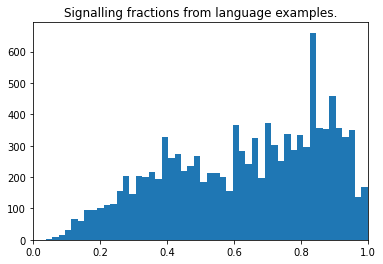

In [14]:
import matplotlib.pyplot as plt
print(f"total number of scenarios: {len(sfs)}.")
plt.hist(sfs, bins=50)
plt.xlim((0,1))
plt.title("Signalling fractions from language examples.")
plt.show()

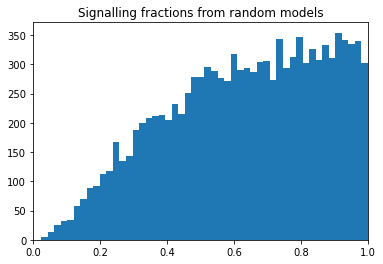

In [15]:
from contextuality.model import random_pr_like_model
random_sfs = []
for i in range(n_scenario):
    model = random_pr_like_model(3)
    random_sfs.append(model.signalling_fraction())

plt.hist(random_sfs, bins=50)
plt.xlim((0,1))
plt.title("Signalling fractions from random models")
plt.show()